In [42]:
import json
import importlib
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid, parse_p_value, tight_bbox, add_jitter, lipid_means
from src.plots import plot_quant_vs_ogtt
import src.Fig4_subplots
importlib.reload(plots)
importlib.reload(src.utils)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'
# sns.set_style('white')

from sklearn.preprocessing import StandardScaler

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [3]:
data['signif_interaction'] = data['qval_sampling:ogtt'] < 0.05
data['signif_sampling'] = data['qval_sampling'] < 0.05
gb_means = (data
            .loc[:, data_cols]
            .groupby(fg['bg_type'], axis=1)
            .mean()
           )

data['fasted_mean'] = gb_means['FBG']
data['fed_mean'] = gb_means['RBG']
data['Log2 Fold Change'] = data['fed_mean'] - data['fasted_mean']

data['Fed - Fasted slope'] = data['coef_fed'] - data['coef_fasted']
data['signif_sampling'] = data['qval_sampling'] < 0.05
data['signif_interact'] = data['qval_sampling:ogtt'] < 0.05
data['log_qval_sampling'] = -np.log10(data['qval_sampling'])
data['log_qval_ogtt'] = -np.log10(data['qval_ogtt'])
data['log_qval_sampling:ogtt'] = -np.log10(data['qval_sampling:ogtt'])
data['is_id'] = data['superclass'] != 'Unidentified'

In [13]:
l_ids = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')].index
data.loc[l_ids, 'fa_carbons']      = data.loc[l_ids, 'ID'].apply(lambda x: parse_lipid(x)[2])
data.loc[l_ids, 'fa_unsat']        = data.loc[l_ids, 'ID'].apply(lambda x: parse_lipid(x)[3])
data.loc[l_ids, 'fa_carbon:unsat'] = data.loc[l_ids, 'ID'].apply(lambda x: parse_lipid(x)[4])
data['pval_asterisks']  = data['qval_sampling:ogtt'].apply(lambda x: parse_p_value(x))
data

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,Fed - Fasted slope,signif_interact,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks
i,,,,,,,,,,,,,,,,,,,,,
m_0,Unidentified_2.353_141.0659,Unidentified,141.06591,2.353,Unidentified,metabolite,-,HILIC,Unidentified,18.724636,...,0.000015,False,0.209851,3.911627,0.092460,False,NaN,NaN,NaN,ns
m_1,Unidentified_11.539_180.0585,Unidentified,180.05850,11.539,Unidentified,metabolite,-,HILIC,Unidentified,20.779580,...,0.000036,True,11.987252,4.759830,3.239845,False,NaN,NaN,NaN,***
m_2,Urocanic acid_11.365_139.0503,Urocanic acid,139.05028,11.365,Nitrogen heterocycle,metabolite,+,HILIC,Nitrogen heterocycle,24.180859,...,-0.000008,False,0.748819,0.233844,0.104163,True,NaN,NaN,NaN,ns
m_3,Uridine_7.513_243.0615,Uridine,243.06152,7.513,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,24.887680,...,0.000004,False,9.482876,0.889251,0.159312,True,NaN,NaN,NaN,ns
m_4,Uric acid_12.732_167.0201,Uric acid,167.02007,12.732,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,27.518513,...,0.000089,False,0.459055,1.250723,0.480416,True,NaN,NaN,NaN,ns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_912,TG 18:0_18:0_18:0_19.885_908.8654,TG 18:0_18:0_18:0,908.86542,19.885,TG,lipid,+,RP,Glycerolipid,19.413597,...,0.000049,True,1.893991,2.856877,1.814371,True,54.0,0.0,54:0,*
l_913,Unidentified_20.144_948.8965,Unidentified,948.89648,20.144,Unidentified,lipid,+,RP,Unidentified,16.606829,...,0.000079,True,1.258580,0.595997,1.828730,False,NaN,NaN,NaN,*
l_914,Unidentified_20.148_897.8253,Unidentified,897.82532,20.148,Unidentified,lipid,+,RP,Unidentified,19.073429,...,0.000057,True,7.730918,0.617574,2.049913,False,NaN,NaN,NaN,**


In [9]:
# Because some lipid IDs overlap in their sum compositions, add some non-random jitter to the x and y values
for cls in ids['molec_class'].unique():
    print(cls, '\n')
    display(ids.loc[ids['molec_class'] == cls, 'fa_carbon:unsat'].value_counts())
    
tgdf = add_jitter('TG', 0.15)
pcdf = add_jitter('PC', 0.1)

AC 



5:0     1
4:0     1
3:0     1
2:0     1
18:2    1
18:1    1
18:0    1
16:1    1
16:0    1
14:1    1
14:0    1
Name: fa_carbon:unsat, dtype: int64

Unidentified 



Series([], Name: fa_carbon:unsat, dtype: int64)

LysoPC 



16:0    3
18:1    3
17:0    2
18:0    2
20:5    1
22:6    1
15:0    1
20:4    1
18:2    1
22:5    1
17:1    1
20:3    1
22:4    1
20:2    1
Name: fa_carbon:unsat, dtype: int64

LysoPE 



18:2    1
16:0    1
18:0    1
Name: fa_carbon:unsat, dtype: int64

FA 



20:2    2
22:5    2
20:5    2
18:1    2
20:3    2
18:2    2
22:6    2
22:0    1
24:1    1
19:1    1
23:0    1
24:0    1
20:0    1
19:0    1
25:0    1
20:1    1
18:0    1
18:4    1
17:0    1
24:5    1
22:4    1
16:0    1
16:1    1
20:4    1
21:5    1
14:0    1
18:3    1
26:0    1
Name: fa_carbon:unsat, dtype: int64

PC 



38:7     4
36:3     4
38:5     3
36:4     3
34:3     2
38:6     2
40:5     2
40:6     2
39:4     2
38:4     2
36:5     2
32:2     1
37:3     1
42:6     1
32:0     1
36:6     1
34:1     1
36:2     1
38:3     1
33:0     1
35:1     1
40:4     1
37:2     1
34:0     1
36:1     1
38:2     1
40:3     1
35:2     1
42:10    1
37:6     1
33:1     1
37:4     1
31:0     1
40:8     1
34:2     1
39:6     1
32:1     1
34:4     1
30:0     1
37:5     1
35:3     1
40:7     1
33:2     1
35:4     1
35:0     1
Name: fa_carbon:unsat, dtype: int64

Alkenyl-DG 



36:5    1
38:6    1
Name: fa_carbon:unsat, dtype: int64

PI 



38:3    2
36:4    1
34:2    1
36:3    1
38:5    1
37:4    1
35:2    1
40:6    1
34:1    1
38:4    1
36:2    1
40:4    1
36:1    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

SM 



40:2    2
41:2    2
40:7    1
42:1    1
41:1    1
43:2    1
40:1    1
42:2    1
39:1    1
42:3    1
38:1    1
32:1    1
37:1    1
36:0    1
36:1    1
35:1    1
36:2    1
34:1    1
33:1    1
36:3    1
34:2    1
43:1    1
Name: fa_carbon:unsat, dtype: int64

Plasmenyl-PC 



38:6    2
34:4    1
36:5    1
40:7    1
32:1    1
36:3    1
40:6    1
38:4    1
34:2    1
36:2    1
34:0    1
Name: fa_carbon:unsat, dtype: int64

Plasmanyl-PC 



38:5    3
36:5    2
38:6    2
36:3    2
34:3    2
34:4    1
34:1    1
36:1    1
40:4    1
42:6    1
40:5    1
36:2    1
38:3    1
32:1    1
32:0    1
38:4    1
40:6    1
34:2    1
36:4    1
33:2    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

Plasmenyl-PE 



40:7    2
38:5    2
36:5    1
38:6    1
36:4    1
36:3    1
34:2    1
40:6    1
38:4    1
34:1    1
36:2    1
40:5    1
42:6    1
40:4    1
36:1    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

PE 



36:4    1
34:2    1
40:6    1
38:4    1
36:2    1
36:1    1
Name: fa_carbon:unsat, dtype: int64

Plasmanyl-PE 



36:4    1
38:5    1
40:6    1
38:4    1
36:2    1
40:5    1
42:6    1
40:4    1
36:1    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

Cer[NS] 



42:2    1
40:1    1
41:1    1
42:1    1
Name: fa_carbon:unsat, dtype: int64

TG 



58:9     3
54:4     3
58:11    3
58:7     3
52:5     2
        ..
48:1     1
46:0     1
52:3     1
49:1     1
54:0     1
Name: fa_carbon:unsat, Length: 81, dtype: int64

CE 



20:5    1
20:4    1
18:2    1
18:1    1
Name: fa_carbon:unsat, dtype: int64

NameError: name 'ids' is not defined

In [26]:
importlib.reload(src.utils)
src.utils.lipid_means(0, 3, data)

,quant,ogtt,insulin,bg_type,week
1091_8_FBG,22.072981,19060.0,653.495,FBG,8
1091_10_FBG,22.599859,19060.0,653.495,FBG,10
1093_8_FBG,22.534322,25057.5,453.485,FBG,8
1093_9_FBG,23.075027,25057.5,453.485,FBG,9
1093_10_FBG,22.552095,25057.5,453.485,FBG,10
1060_8_FBG,22.516857,48742.5,422.940,FBG,8
1060_9_FBG,22.716599,48742.5,422.940,FBG,9
1060_10_FBG,22.385952,48742.5,422.940,FBG,10
1062_8_FBG,22.319809,43717.5,432.020,FBG,8
1062_9_FBG,22.507527,43717.5,432.020,FBG,9


In [46]:
data.loc['m_1', data_cols].mean()

21.196031636116132

In [66]:
data.loc[data.index, data_cols].mean()

1091_8_FBG     21.164533
1091_10_FBG    21.399226
1093_8_FBG     21.397182
1093_9_FBG     21.653521
1093_10_FBG    21.357216
1060_8_FBG     21.331545
1060_9_FBG     21.530112
1060_10_FBG    21.286423
1062_8_FBG     21.426828
1062_9_FBG     21.493169
1062_10_FBG    21.347785
1074_8_FBG     21.816091
1074_9_FBG     21.338945
1074_10_FBG    21.457368
1092_8_FBG     21.190762
1092_9_FBG     21.499940
1092_10_FBG    21.365854
1102_8_FBG     21.648726
1102_9_FBG     21.563003
1102_10_FBG    21.693599
1076_8_FBG     21.843011
1076_9_FBG     21.586305
1076_10_FBG    21.212666
1082_8_FBG     21.458721
1082_9_FBG     21.131142
1082_10_FBG    21.150569
1101_8_FBG     21.172921
1101_9_FBG     21.513445
1101_10_FBG    21.343908
1091_8_RBG     21.238953
1091_9_RBG     21.471991
1091_10_RBG    20.768363
1093_8_RBG     21.237669
1093_9_RBG     21.684146
1093_10_RBG    21.460046
1060_8_RBG     21.597348
1060_9_RBG     21.487375
1060_10_RBG    21.560245
1062_8_RBG     21.980285
1062_9_RBG     21.756122


In [63]:
data.loc[data.index, data_cols].mean().to_frame()

,0
1091_8_FBG,21.164533
1091_10_FBG,21.399226
1093_8_FBG,21.397182
1093_9_FBG,21.653521
1093_10_FBG,21.357216
1060_8_FBG,21.331545
1060_9_FBG,21.530112
1060_10_FBG,21.286423
1062_8_FBG,21.426828
1062_9_FBG,21.493169


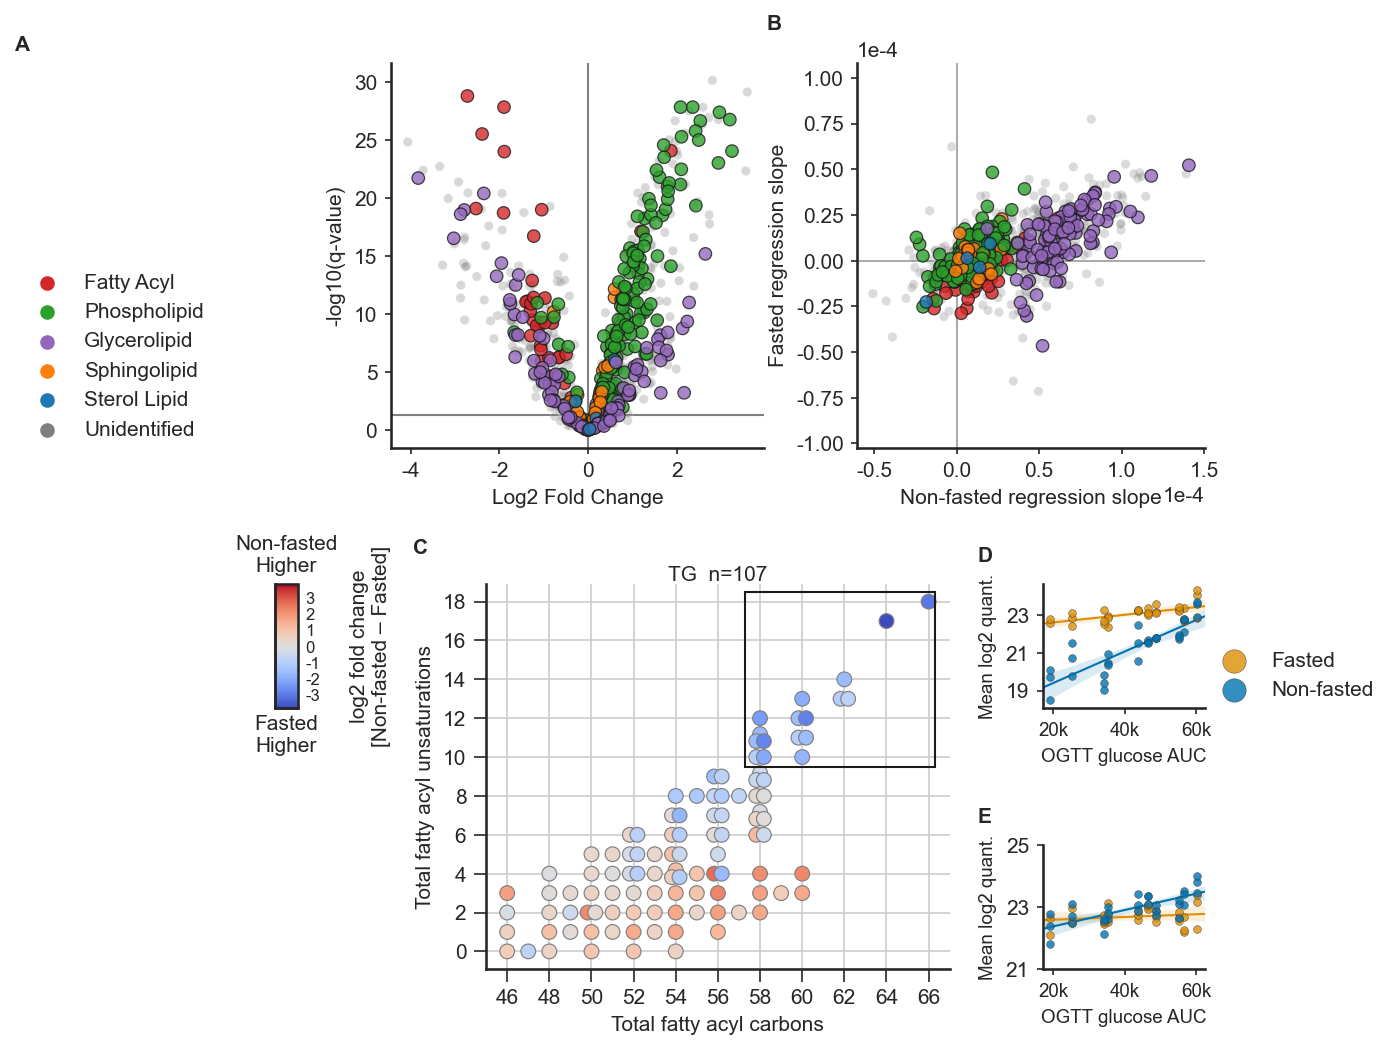

In [88]:
importlib.reload(src.Fig4_subplots)
tgdf = src.utils.add_jitter('TG', data, 0.15)

fig, axs = plt.subplot_mosaic(
    '''
    .AAABB
    .AAABB
    x.CCCD
    ..CCCE
    ''',
    dpi=150, figsize=(8,8), facecolor='white',
    gridspec_kw=dict(wspace=1.2, hspace=1.1, 
                     width_ratios=[1, 0.1, 4, 4, 4, 7],
                     height_ratios=[1, 1, 1, 1]),
)

axvol = plots.volcano(x='Log2 Fold Change', y='log_qval_sampling', 
                      df=data, metab_type='lipid', ax=axs['A'], legend=True)
axvol.legend(loc=(-1, 0))
axslopes = plots.fasted_fed_slope('lipid', alpha=0.8, ax=axs['B'])
axvol.tick_params(length=3)
axslopes.tick_params(length=3)

ax = src.Fig4_subplots.make_carbon_unsat_plot('TG', 0.18, ax=axs['C'], cax=axs['x'])
num_tg = ids.loc[ids['molec_class'] == 'TG'].shape[0]
axs['C'].set_title(f'TG  n={num_tg}', fontsize=10, pad=0)
for xy, width, height in [
#     ((45.5, -0.5), 13, 3), ((45.5, 2.5), 15, 3), ((51.3, 5.5), 7.5, 4), 
    ((57.3, 9.5), 9, 9)
]:
    ax.add_patch(patches.Rectangle(xy, width, height, linewidth=1, edgecolor='0.1', facecolor='none'))

for unsat_low, unsat_high, subplot in [(0, 99, 'E'), (10, 99, 'D')]:  # (0, 2, 'C'), (3, 5, 'D'), (6, 9, 'E'), 
    idxs = data.loc[(data['fa_unsat'] >= unsat_low) & (data['fa_unsat'] <= unsat_high)].index
    plot_quant_vs_ogtt(idxs, animal_lines=False, 
#                        xlabel='OGTT glucose AUC', ylabel='Mean log2 quant.', 
                       scatter_kws={'s': 14, 'edgecolor': '0.2', 'linewidth': 0.25, 'zorder': 10}, 
                       line_kws={'linewidth': 1}, ax=axs[subplot])

fs=9   
axs['B'].set_xlabel('Non-fasted regression slope')
axs['B'].set_ylabel('Fasted regression slope')
axs['D'].legend(loc=(1, 0), handles=axs['D'].get_legend_handles_labels()[0], labels=['Fasted', 'Non-fasted'],
                markerscale=3,)
axs['D'].tick_params(length=3)
axs['D'].set_yticks([19, 21, 23], fontsize=fs)
axs['D'].set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'], fontsize=fs)
axs['D'].set_ylabel('Mean log2 quant.', fontsize=fs)
axs['D'].set_xlabel('OGTT glucose AUC', fontsize=fs)
axs['E'].tick_params(length=3)
axs['E'].set_yticks([21, 23, 25], fontsize=fs)
axs['E'].set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'], fontsize=fs)
axs['E'].set_ylabel('Mean log2 quant.', fontsize=fs)
axs['E'].set_xlabel('OGTT glucose AUC', fontsize=fs)

# handles, labels = axs['B'].get_legend_handles_labels()
# axs['B'].legend(handles=handles, labels=['Fasted', 'Non-fasted'], loc=(-1.4, 0.5), markerscale=2, title='Sampling')
axs['x'].text(s='Fasted\nHigher', x=0.5, y=-0.05, transform=axs['x'].transAxes, ha='center', va='top')
# axs['x'].yaxis.set_label_position('left')

for ax_letter, ax in axs.items():
    if ax_letter == 'x':
        continue
    bb = tight_bbox(ax)
    ax.text(s=ax_letter, x=bb.x0-0.002, y=bb.y1+0.01, fontweight='bold', transform=fig.transFigure)

# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.png', dpi=200, bbox_inches='tight', facecolor='white')
# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.pdf', dpi=200, bbox_inches='tight', facecolor='white')

# Old version 

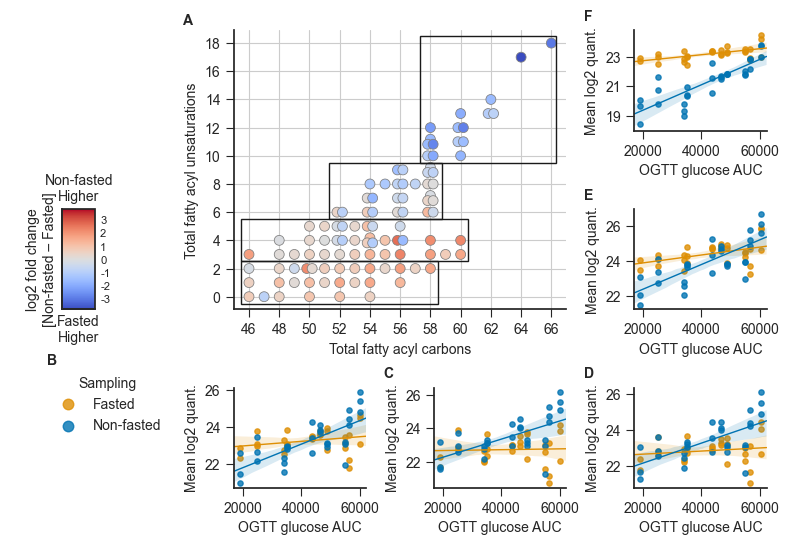

In [7]:
fig, axs = plt.subplot_mosaic(
    '''
    ..AAF
    x.AAE
    ..BCD
    ''',
    dpi=101, figsize=(9, 6), gridspec_kw=dict(wspace=0.78, hspace=0.78, width_ratios=[1, 0.1, 4, 4, 4]),
)
ax = make_carbon_unsat_plot('TG', 0.18, ax=axs['A'], cax=axs['x'])
# num_tg = ids.loc[ids['molec_class'] == 'TG'].shape[0]
# plt.title(f'Triacylglycerol (TG)\nn={num_tg}', fontsize=18)
# print(ax.get_xlim(), ax.get_ylim())
for xy, width, height in [((45.5, -0.5), 13, 3), ((45.5, 2.5), 15, 3), ((51.3, 5.5), 7.5, 4), ((57.3, 9.5), 9, 9)]:
    ax.add_patch(patches.Rectangle(xy, width, height, linewidth=1, edgecolor='0.1', facecolor='none'))
# ax.text(s='C', x=59, y=1, fontweight='bold', fontsize=10, va='center', ha='center')
# ax.text(s='D', x=61, y=4, fontweight='bold', fontsize=10, va='center', ha='center')
# ax.text(s='E', x=59.2, y=7.5, fontweight='bold', fontsize=10, va='center', ha='center')
# ax.text(s='F', x=63, y=8.8, fontweight='bold', fontsize=10, va='center', ha='center')

for unsat_low, unsat_high, subplot in [(0, 99, 'B'), (0, 2, 'C'), (3, 5, 'D'), (6, 9, 'E'), (10, 99, 'F')]:
    plot_quant_vs_ogtt(lipid_means(unsat_low, unsat_high), x='ogtt', y='quant', palette=colors, 
                       animal_lines=False, xlabel='OGTT glucose AUC', ylabel='Mean log2 quant.', 
                       scatter_kws={'s': 14}, line_kws={'linewidth': 1}, ax=axs[subplot])
    
axs['F'].set_yticks([19, 21, 23])
handles, labels = axs['B'].get_legend_handles_labels()
axs['B'].legend(handles=handles, labels=['Fasted', 'Non-fasted'], loc=(-1.4, 0.5), markerscale=2, title='Sampling')
axs['x'].text(s='Fasted\nHigher', x=0.5, y=-0.05, transform=axs['x'].transAxes, ha='center', va='top')
axs['x'].yaxis.set_label_position('left')

for ax_letter, ax in axs.items():
    if ax_letter == 'x':
        continue
    bb = tight_bbox(ax)
    ax.text(s=ax_letter, x=bb.x0-0.002, y=bb.y1+0.01, fontweight='bold', transform=fig.transFigure)

# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.png', dpi=200, bbox_inches='tight', facecolor='white')
# plt.savefig(r'..\reports\figures\Figure_TGs\FA_unsat_carbons_mean_regplots.pdf', dpi=200, bbox_inches='tight', facecolor='white')

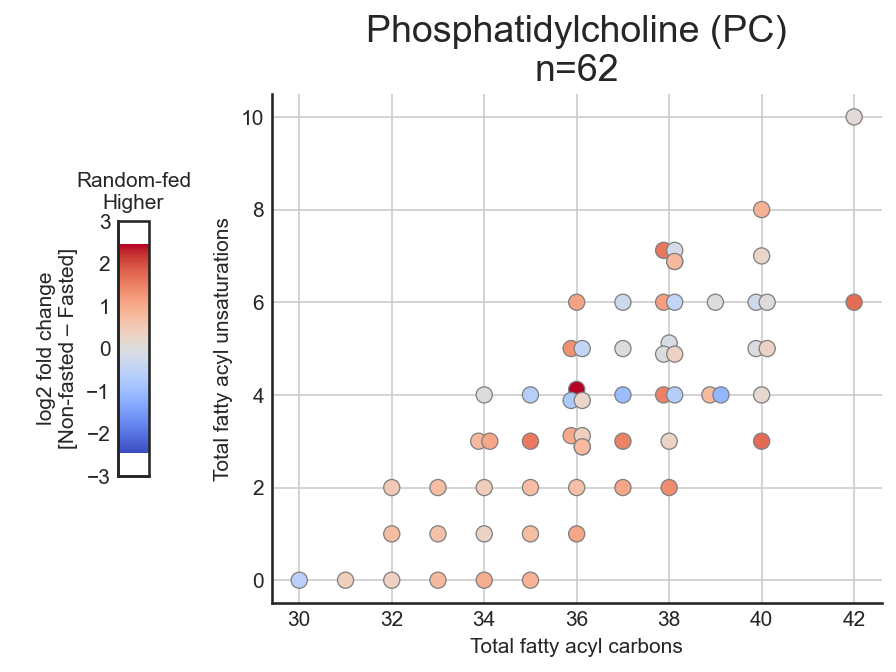

In [121]:
make_carbon_unsat_plot('PC', 0.12)
num = ids.loc[ids['molec_class'] == 'PC'].shape[0]
plt.title(f'Phosphatidylcholine (PC)\nn={num}', fontsize=18)

plt.savefig(r'..\reports\figures\4-5-4\PC_log2fc.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-5-4\PC_log2fc.svg', dpi=150, bbox_inches='tight')

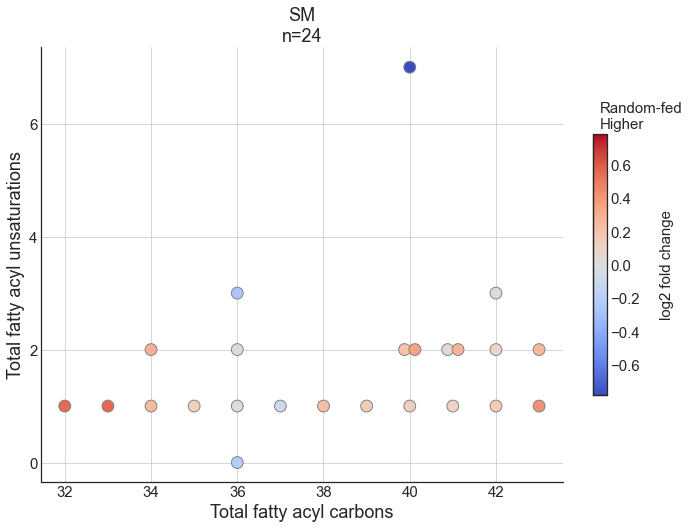

In [378]:
make_carbon_unsat_plot('SM', 0.12)

num = ids.loc[ids['molec_class'] == 'SM'].shape[0]
plt.title(f'SM\nn={num}', fontsize=18)

plt.savefig(r'..\reports\figures\4-5-4\SM_log2fc.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-5-4\SM_log2fc.svg', dpi=150, bbox_inches='tight')

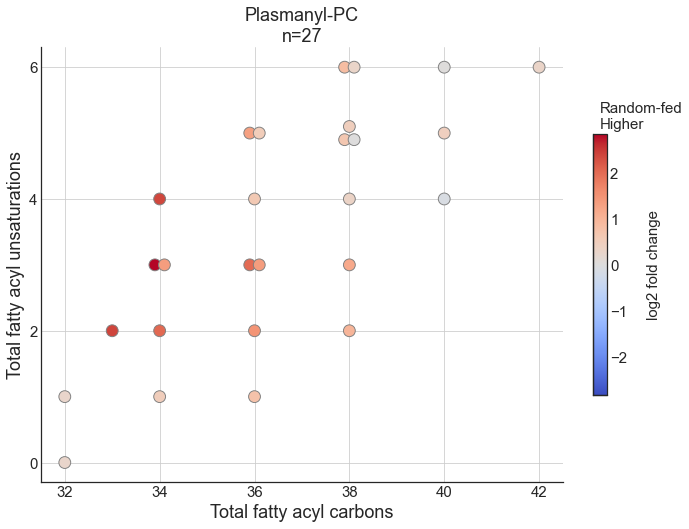

In [379]:
lipid_class = 'Plasmanyl-PC'

make_carbon_unsat_plot(lipid_class, 0.1)

num = ids.loc[ids['molec_class'] == lipid_class].shape[0]
plt.title(f'{lipid_class}\nn={num}', fontsize=18)

plt.savefig(r'..\reports\figures\4-5-4\PlasmanylPC_log2fc.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-5-4\PlasmanylPC_log2fc.svg', dpi=150, bbox_inches='tight')

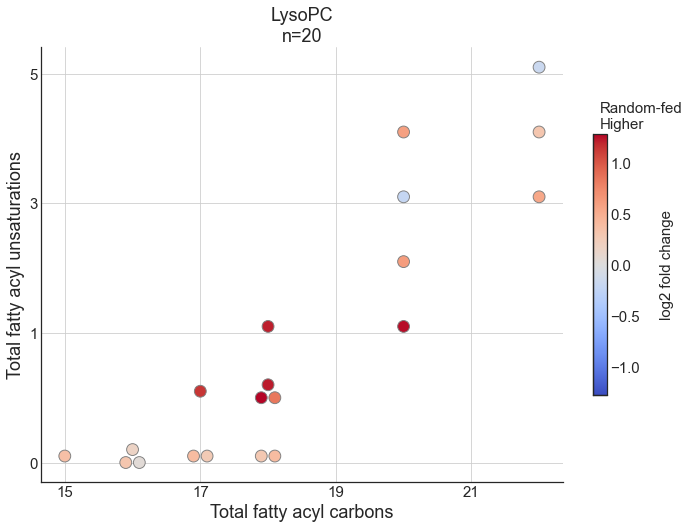

In [380]:
lipid_class = 'LysoPC'

make_carbon_unsat_plot(lipid_class, 0.1)

num = ids.loc[ids['molec_class'] == lipid_class].shape[0]
plt.title(f'{lipid_class}\nn={num}', fontsize=18)

plt.savefig(r'..\reports\figures\4-5-4\LysoPC_log2fc.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-5-4\LysoPC_log2fc.svg', dpi=150, bbox_inches='tight')

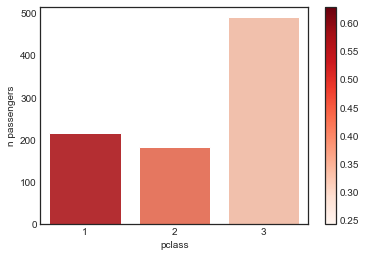

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
titanic = sns.load_dataset("titanic")
g = titanic.groupby('pclass')
survival_rates = g['survived'].mean()
n = g.size()
norm = plt.Normalize(survival_rates.min(), survival_rates.max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax = sns.barplot(x=n.index, y=n, hue=survival_rates, palette='Reds', dodge=False)
ax.set_ylabel('n passengers')
ax.get_legend().remove()
ax.figure.colorbar(sm)

In [ ]:
# for i, cls in enumerate(['TG','PC','LysoPC', 'PI', 
#             'PE',  'SM',
#             'Plasmanyl-PC', 'Plasmenyl-PC', 'Plasmanyl-PE', 'Plasmenyl-PE']):

fig, axs = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(11, 8)
# lipid_classes = ['TG', 'PC', 'SM', 'Plasmanyl-PC']
lipid_classes = ['TG']
for i, cls in enumerate(lipid_classes):
#     ax_row, ax_col = divmod(i, 2)
#     ax = axs[ax_row][ax_col]
    ax = axs
#     df = ids.loc[(data['molec_class'] == cls) & (data['qval_sampling:ogtt'] < 0.1)]
    df = tgdf
    max_C, min_C = df['fa_carbons'].max(), df['fa_carbons'].min()
    max_unsat, min_unsat = df['fa_unsat'].max(), df['fa_unsat'].min()
    C_unsat_combos = set(ids.loc[data['molec_class'] == cls].value_counts(['fa_carbons', 'fa_unsat']).index)
    sns.scatterplot(
        data=df, x='fa_carbons', y='fa_unsat',
#         size='-log10 p-value', sizes=(10, 200),
#         size='pval_asterisks', sizes={'ns': 20, '*': 55, '**': 75, '***': 110, '****': 120},
        s=100,
#         style='pval_asterisks', markers={'ns': '^','*':'o'},
        hue='log2 FC', 
        hue_norm=TwoSlopeNorm(vcenter=0.0, vmin=df['log2 FC'].min(), vmax=df['log2 FC'].max()), 
        palette='coolwarm',  # GnBu  viridis_r
        legend=('brief' if i == 0 else False),
        edgecolor='gray',        
        ax=ax
    )
    ax.set_title(f'{cls}  n={len(df)}', fontsize=17)
    ax.set_xticks(np.arange(min_C, max_C+1, 2))
    ax.set_xticklabels([int(x) for x in np.arange(min_C, max_C+1, 2)], fontsize=15)
    ax.set_yticks(np.arange(min_unsat, max_unsat+1, 2))
    ax.set_yticklabels([int(x) for x in np.arange(min_unsat, max_unsat+1, 2)], fontsize=15)
    ax.grid(alpha=0.45)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
#     ax.set_background('gray')
#     if i == 1:
#         ax.legend(loc=(1.12, -1), markerscale=1.7, fontsize=16)
# fig.legend(loc=('lower right'), bbox_to_anchor=(1.22, 0.1), markerscale=1.2, fontsize=18)
# plt.legend(loc=(1.02, 0.2))
ax.legend(title='log2 fold change', loc=(1.01, 0.5), markerscale=1.5, fontsize=15, title_fontsize=18)

fig.suptitle('Lipids by class significant under glucose tolerance', fontsize=18)
fig.supylabel('Total fatty acyl unsaturations', fontsize=18)
fig.supxlabel('Total fatty acyl carbons', fontsize=18)
fig.set_facecolor('white')
# plt.grid()
plt.tight_layout()
sns.despine()
# plt.savefig(r'..\reports\figures\4-5-4\TG_.png', bbox_inches='tight')

In [69]:
ids.loc[data['Compound Class'] == 'TG'].value_counts(['fa_carbons', 'fa_unsat']).iloc[0:30]

fa_carbons  fa_unsat
54          4           3
58          9           3
60          11          3
58          7           3
            11          3
54          5           2
56          4           2
52          6           2
            5           2
            4           2
56          6           2
            8           2
54          7           2
58          6           2
            8           2
54          6           2
58          10          2
62          13          2
60          12          2
64          17          1
54          8           1
55          2           1
            3           1
            4           1
            8           1
56          1           1
            2           1
            3           1
62          14          1
56          5           1
dtype: int64

In [58]:
set(ids.loc[data['Compound Class'] == 'TG'].value_counts(['fa_carbons', 'fa_unsat']).index)

{(46, 0),
 (46, 1),
 (46, 2),
 (46, 3),
 (47, 0),
 (48, 0),
 (48, 1),
 (48, 2),
 (48, 3),
 (49, 0),
 (49, 1),
 (49, 2),
 (49, 3),
 (50, 0),
 (50, 1),
 (50, 2),
 (50, 3),
 (50, 4),
 (50, 5),
 (51, 1),
 (51, 2),
 (51, 3),
 (51, 4),
 (51, 5),
 (52, 0),
 (52, 1),
 (52, 2),
 (52, 3),
 (52, 4),
 (52, 5),
 (52, 6),
 (53, 1),
 (53, 2),
 (53, 3),
 (53, 4),
 (53, 5),
 (54, 0),
 (54, 1),
 (54, 2),
 (54, 3),
 (54, 4),
 (54, 5),
 (54, 6),
 (54, 7),
 (54, 8),
 (55, 2),
 (55, 3),
 (55, 4),
 (55, 8),
 (56, 1),
 (56, 2),
 (56, 3),
 (56, 4),
 (56, 5),
 (56, 6),
 (56, 7),
 (56, 8),
 (56, 9),
 (57, 2),
 (57, 8),
 (58, 2),
 (58, 3),
 (58, 4),
 (58, 6),
 (58, 7),
 (58, 8),
 (58, 9),
 (58, 10),
 (58, 11),
 (58, 12),
 (59, 3),
 (60, 3),
 (60, 4),
 (60, 10),
 (60, 11),
 (60, 12),
 (60, 13),
 (62, 13),
 (62, 14),
 (64, 17),
 (66, 18)}

<AxesSubplot:xlabel='fa_carbons', ylabel='fa_unsat'>

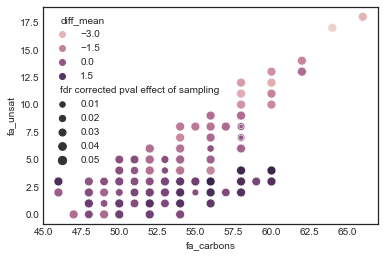

In [29]:
sns.scatterplot(data=ids.loc[ids['Compound Class'] == 'TG'], x='fa_carbons', y='fa_unsat', 
                size=q_samp, sizes=(80, 20),
                hue='diff_mean')

In [ ]:
np.arange()

In [83]:
# def make_carbon_unsat_plot_pval(lipid_class, jitter_offset, pval):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
#     df = add_jitter(lipid_class, os=jitter_offset)
#     max_C, min_C = df['fa_carbons'].max(), df['fa_carbons'].min()
#     max_unsat, min_unsat = df['fa_unsat'].max(), df['fa_unsat'].min()
# #     norm = CenteredNorm(vcenter=0.0, )
#     norm = Normalize(vmin=df[pval].min(), vmax=df[pval].max())
#     cmap = 'Reds'  # GnBu  viridis_r
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
#     sns.scatterplot(
#         data=df, x='fa_carbons', y='fa_unsat',
#     #         size='-log10 p-value', sizes=(10, 200),
#     #         size='pval_asterisks', sizes={'ns': 20, '*': 55, '**': 75, '***': 110, '****': 120},
#         s=140,
# #         style='pval_asterisks', markers={'ns': '^','*':'o', '**': '*'}, sizes={'ns': 100, '*': 100, '**':500},
#         hue=pval, 
#         hue_norm=norm, 
#         palette=cmap,  
# #         legend=('brief' if i == 0 else False),
#         legend=False,
#         edgecolor='gray', ax=ax)
#     ax.set_xticks(np.arange(min_C, max_C+1, 2))
#     ax.set_xticklabels([int(x) for x in np.arange(min_C, max_C+1, 2)], fontsize=15)
#     ax.set_yticks(np.arange(min_unsat, max_unsat+1, 2))
#     ax.set_yticklabels([int(x) for x in np.arange(min_unsat, max_unsat+1, 2)], fontsize=15)
#     plt.grid(color='#CCCCCC')
# #     plt.legend(title='log2 fold change', loc=(1.01, 0.5), markerscale=1.5, fontsize=15, title_fontsize=18)
# #     plt.title('Lipids by class significant under glucose tolerance', fontsize=18)
#     plt.ylabel('Total fatty acyl unsaturations', fontsize=18)
#     plt.xlabel('Total fatty acyl carbons', fontsize=18)
#     cb = ax.figure.colorbar(sm, shrink=0.6, fraction=0.1)
#     cb.ax.tick_params(labelsize=15)
#     cb.set_label(label='-log10 p-value', fontsize=15)
#     # plt.tight_layout()
#     sns.despine()
#     # plt.savefig(r'..\reports\figures\4-5-4\TG_.png', bbox_inches='tight')
# make_carbon_unsat_plot_pval('TG', 0.20, '-log10_pval_ogtt')

# num_tg = ids.loc[ids['molec_class'] == 'TG'].shape[0]
# plt.title(f'Triacylglycerol (TG)\nn={num_tg}', fontsize=18)
# # plt.savefig(r'..\reports\figures\4-5-4\TG_pval_interaction.png', dpi=150, bbox_inches='tight')
# # plt.savefig(r'..\reports\figures\4-5-4\TG_pval_interaction.svg', dpi=150, bbox_inches='tight')

<AxesSubplot:>

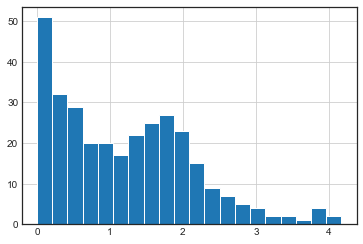

In [74]:
ids['-log10 p-value'].hist(bins=20)

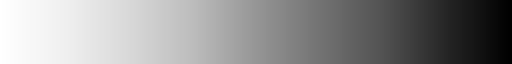

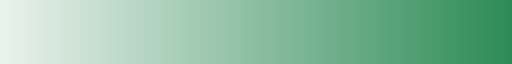

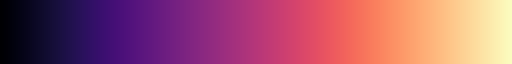

In [77]:
display(sns.color_palette('Greys', as_cmap=True))
display(sns.light_palette('seagreen', as_cmap=True))
display(sns.color_palette('magma', as_cmap=True))